## Training the Neural Additive Model (NAM)

To train the model, run the following command:

```bash
python -m neural_additive_models.nam_train \
  --dataset_name=Correlated \
  --training_epochs=1000 \
  --regression=True \
  --logdir=./correlated \
  --batch_size=1024 \
  --learning_rate=0.00674 \
  --dropout=0 \
  --fold_num=1 \
  --output_regularization=0.001 \
  --l2_regularization=1e-6 \
  --debug=True \
  --activation=relu


In [1]:
import neural_additive_models.data_utils as data_utils
import neural_additive_models.graph_builder as graph_builder

import os.path as osp

In [2]:
from utils import load_col_min_max, inverse_min_max_scaler

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
dataset_name = 'Correlated'
is_regression = dataset_name in ['Housing', 'Fico']
housing_data =  data_utils.load_dataset(dataset_name)
data_x, data_y, column_names = housing_data
col_min_max = load_col_min_max(dataset_name)

In [4]:
from utils import load_nam_checkpoint
import numpy as np

ckpt_dir = r".\correlated\fold_1\split_1\model_0\best_checkpoint"
nam, sess = load_nam_checkpoint(ckpt_dir)

Using checkpoint: .\correlated\fold_1\split_1\model_0\best_checkpoint\model.ckpt-1690
Feature widths: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
Num input features: 10
INFO:tensorflow:Restoring parameters from .\correlated\fold_1\split_1\model_0\best_checkpoint\model.ckpt-1690
✅ Restored NAM from checkpoint.


In [5]:
from utils import get_test_predictions, compute_features, get_feature_predictions

# --- Test set predictions ---
test_predictions = get_test_predictions(nam, data_x.astype(np.float32), sess)
print("Predictions length:", len(test_predictions))

# --- Feature-wise predictions (shape functions) ---
unique_features = compute_features(dataset_name)
feature_predictions = get_feature_predictions(nam, dataset_name, sess)

# --- Evaluate RMSE or AUROC ---

is_regression = True
test_metric = graph_builder.calculate_metric(
    data_y, test_predictions, regression=is_regression)
metric_str = 'RMSE' if is_regression else 'AUROC'
print(f'{metric_str}: {test_metric:.4f}')


Predictions length: 20000
RMSE: 0.5029


In [6]:
from utils import prepare_feature_arrays, get_dataset_config, compute_mean_predictions

# Step 1: Prepare data
SINGLE_FEATURES_ORIGINAL, UNIQUE_FEATURES_ORIGINAL, UNIQUE_FEATURES = prepare_feature_arrays(
    data_x, column_names, col_min_max, inverse_min_max_scaler
)

# Step 2: Load dataset-specific config
COL_NAMES, FEATURE_LABEL_MAPPING, CATEGORICAL_NAMES = get_dataset_config(dataset_name, column_names)

# Step 3: Align predictions
avg_hist_data, MEAN_PRED, ALL_INDICES = compute_mean_predictions(
    data_x, column_names, UNIQUE_FEATURES, feature_predictions
)


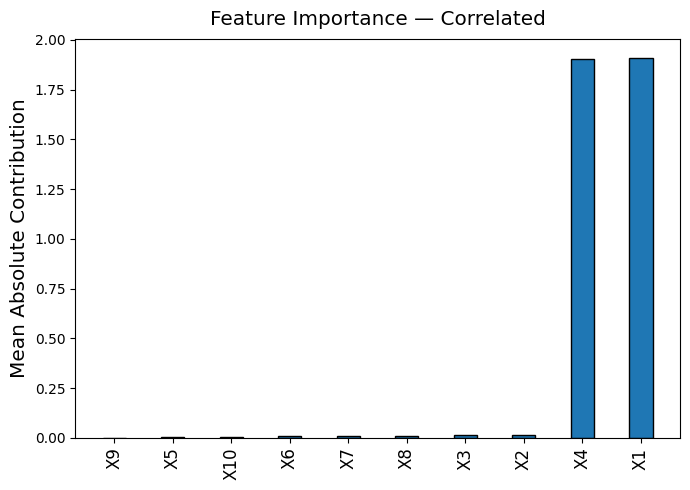

In [7]:
from utils import compute_mean_feature_importance, plot_mean_feature_importance

feature_names, importances = compute_mean_feature_importance(avg_hist_data, MEAN_PRED)
fig = plot_mean_feature_importance(feature_names, importances, dataset_name)

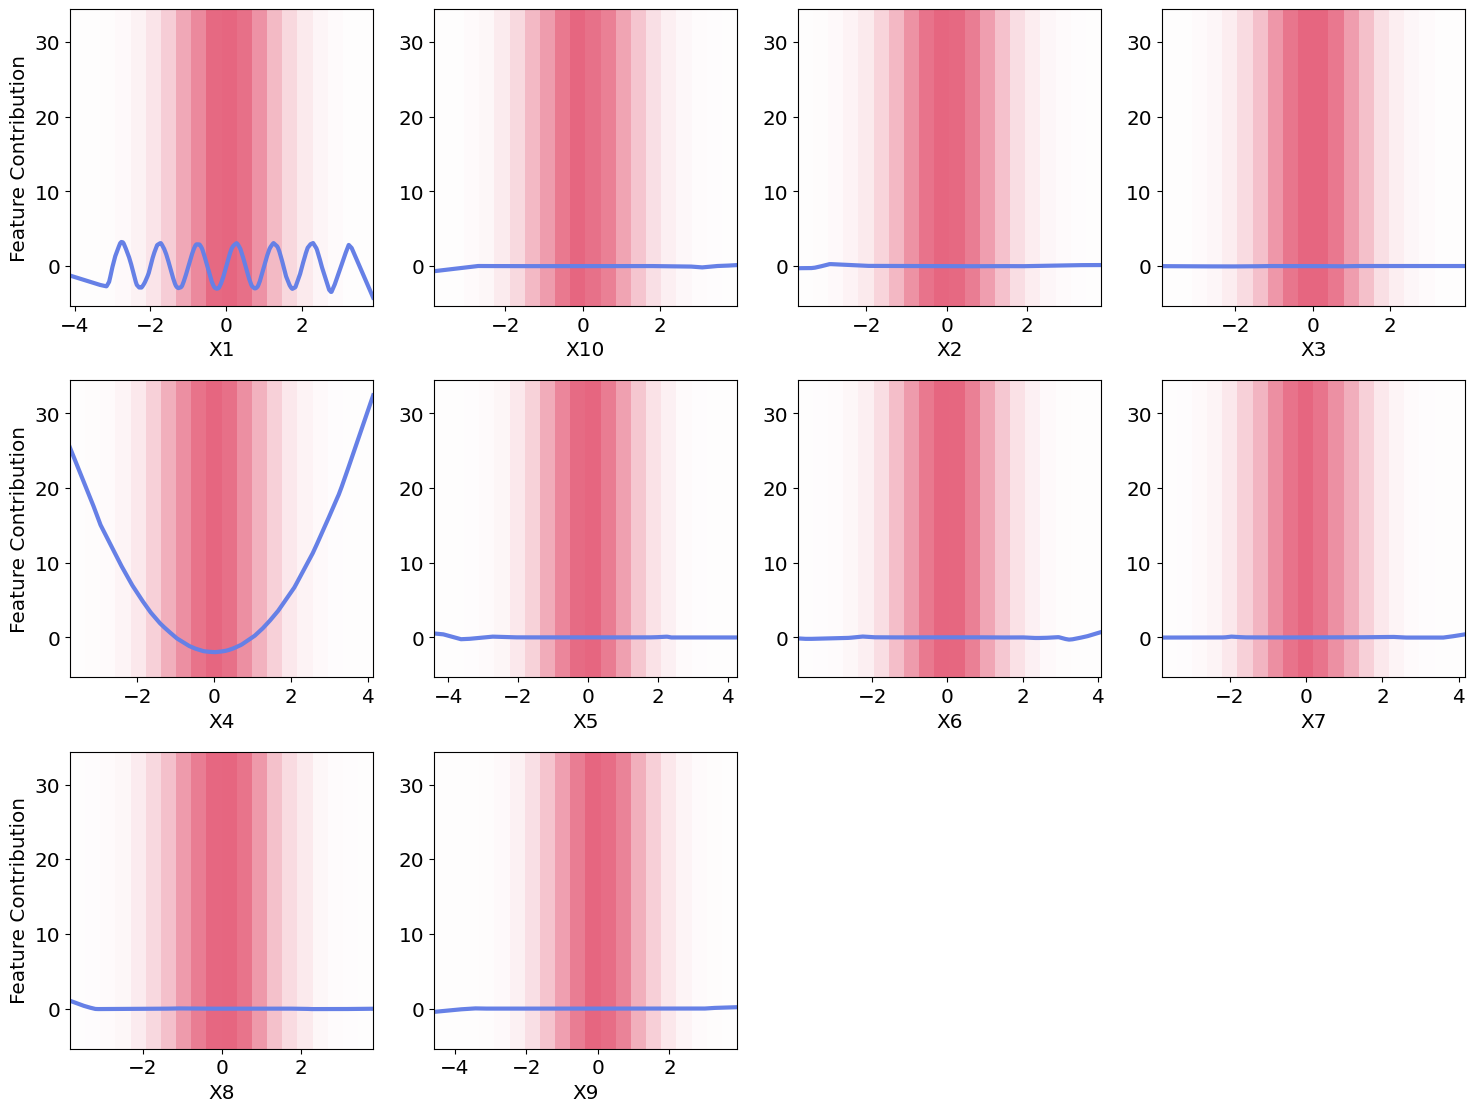

In [8]:
from utils import plot_nam_contributions_with_density
plt = plot_nam_contributions_with_density(
    hist_data=avg_hist_data,
    unique_features=UNIQUE_FEATURES_ORIGINAL,
    single_features=SINGLE_FEATURES_ORIGINAL,
    categorical_names=CATEGORICAL_NAMES,
    col_mapping=COL_NAMES[dataset_name],
    feature_mapping=FEATURE_LABEL_MAPPING[dataset_name],
    mean_pred=MEAN_PRED,
    feature_to_use=column_names
)
